In [ ]:
'''
Dataset - Flicker30k
https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset?resource=download
'''

'''
Model implementation - CLIP (PyTorch)
https://towardsdatascience.com/simple-implementation-of-openai-clip-model-a-tutorial-ace6ff01d9f2
'''

'\nModel implementation - CLIP (PyTorch)\nhttps://towardsdatascience.com/simple-implementation-of-openai-clip-model-a-tutorial-ace6ff01d9f2\n'

# Imports 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Industry/Inkers/

/content/gdrive/MyDrive/Industry/Inkers


In [ ]:
!pip install timm
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.3 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

<ipython-input-6-2540d8c9d86b>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Downloading Dataset

In [ ]:
# !pip install kaggle --upgrade
# os.environ['KAGGLE_USERNAME'] = ## Kaggle username
# os.environ['KAGGLE_KEY'] = ## Kaggle pwd

# ## For Flickr 30k
# !kaggle datasets download -d hsankesara/flickr-image-dataset
# !unzip flickr-image-dataset.zip
# dataset = "30k"

In [ ]:
image_path = "flickr30k_images/flickr30k_images"
captions_path = "."

In [ ]:
df = pd.read_csv("captions.csv")

In [ ]:
df.head(10)

,image,caption_number,caption,id
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...,0
1,1000092795.jpg,1,"Two young , White males are outside near many ...",0
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,0
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,0
4,1000092795.jpg,4,Two friends enjoy time spent together .,0
5,10002456.jpg,0,Several men in hard hats are operating a giant...,1
6,10002456.jpg,1,Workers look down from up above on a piece of ...,1
7,10002456.jpg,2,Two men working on a machine wearing hard hats .,1
8,10002456.jpg,3,Four men on top of a tall structure .,1
9,10002456.jpg,4,Three men on a large rig .,1


In [ ]:
# Stored the data in a dictionary with keys as their file names 
# Google colab fails to find filles when the number of files in a directory is very large 

images_dict_all = np.load('dataset/images_dict_all.npy', allow_pickle=True).item()

# Model

## Loading the pretrained ViT model 

In [ ]:
! pip install pytorch_pretrained_vit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch_pretrained_vit: filename=pytorch_pretrained_vit-0.0.7-py3-none-any.whl size=11130 sha256=a6b9124b49d77d0f11069d06961bda064d5ba5fe94f5cd30c3da323b5e9270fc
  Stored in directory: /root/.cache/pip/wheels/20/16/21/ea75e637c84ae6e3d2c4a546a1f28d19df704ff95ddb77bd47
Successfully built pytorch_pretrained_vit


In [ ]:
from pytorch_pretrained_vit import ViT

## CFG class for hyper-parameters

In [ ]:
class CFG:
  
    debug = False
    image_path = image_path
    captions_path = captions_path
    batch_size = 32
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'B_16_imagenet1k'
    image_embedding = 1000

    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 384

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256 
    dropout = 0.1

In [ ]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


In [ ]:
class CLIPDataset(torch.utils.data.Dataset):

    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names 
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = images_dict_all[self.image_filenames[idx]]
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

In [ ]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = ViT(CFG.model_name, pretrained=CFG.pretrained)

        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
      return self.model(x)

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

In [ ]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [ ]:
class CLIPModel(nn.Module):

    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):

        # Getting Image and Text Features        
        image_features = self.image_encoder(batch["image"])
        
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [ ]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{CFG.captions_path}/captions.csv")
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

In [ ]:
import pickle

In [ ]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter


def main():
    train_df, valid_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")

            pkl_filename = "best_model.pkl"
            with open(pkl_filename, 'wb') as file:
              pickle.dump(model, file)
        
        lr_scheduler.step(valid_loss.avg)

In [ ]:
main()

Loaded pretrained weights.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 1


  0%|          | 0/3973 [00:00<?, ?it/s]

  0%|          | 0/994 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2


  0%|          | 0/3973 [00:00<?, ?it/s]

  0%|          | 0/994 [00:00<?, ?it/s]

# Inference

In [ ]:
def get_image_text_embeddings(valid_df, model_path):

    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")
    
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()
    
    valid_image_embeddings = []
    valid_text_embeddings = []

    with torch.no_grad():
        for batch in tqdm(valid_loader):

          image_features = model.image_encoder(batch["image"].to(CFG.device))
          image_embeddings = model.image_projection(image_features)
          valid_image_embeddings.append(image_embeddings)

          text_features = model.text_encoder(input_ids=batch["input_ids"].to(CFG.device), attention_mask=batch["attention_mask"].to(CFG.device))
          text_embeddings = model.text_projection(text_features)
          valid_text_embeddings.append(text_embeddings)

    return model, torch.cat(valid_image_embeddings), torch.cat(valid_text_embeddings)

In [ ]:
_, valid_df = make_train_valid_dfs()
model, image_embeddings, text_embeddings = get_image_text_embeddings(valid_df, "best.pt")

Downloading: "https://github.com/lukemelas/PyTorch-Pretrained-ViT/releases/download/0.0.2/B_16_imagenet1k.pth" to /root/.cache/torch/hub/checkpoints/B_16_imagenet1k.pth


  0%|          | 0.00/331M [00:00<?, ?B/s]

Loaded pretrained weights.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/994 [00:00<?, ?it/s]

In [ ]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):

    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)

    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }
    
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)
    
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]
    
    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
      
      image = images_dict_all[match]
      ax.imshow(image)
      ax.axis("off")
    
    plt.show()

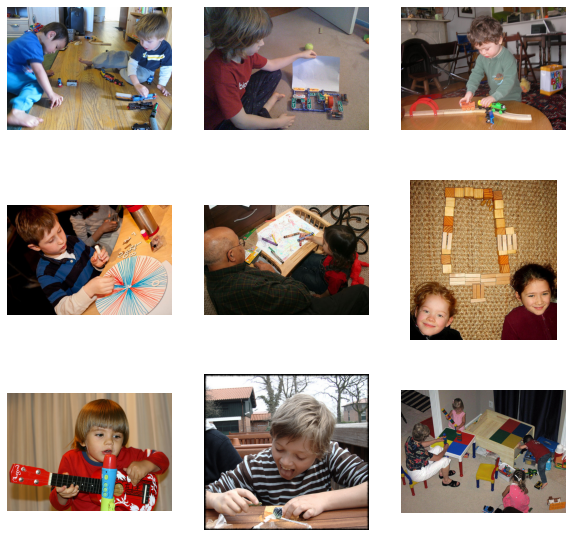

In [ ]:
find_matches(model, 
             image_embeddings,
             query="boy playing",
             image_filenames=valid_df['image'].values,
             n=9)

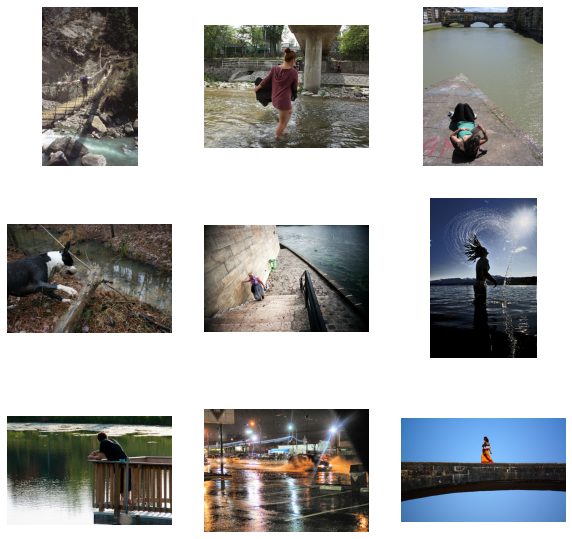

In [ ]:
find_matches(model, 
             image_embeddings,
             query="water",
             image_filenames=valid_df['image'].values,
             n=9)

In [ ]:
def find_matches_image_query(model, image_embeddings, text_embeddings, valid_df, valid_df_query):

  tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
  valid_loader = build_loaders(valid_df_query, tokenizer, mode="valid")

  valid_image_query_embeddings = []

  with torch.no_grad():
    for batch in tqdm(valid_loader):

      image_query_features = model.image_encoder(batch["image"].to(CFG.device))
      image_query_embeddings = model.image_projection(image_query_features)
      valid_image_query_embeddings.append(image_query_embeddings)
  
  image_from_query_embeddings = torch.cat(valid_image_query_embeddings)
  image_from_query_embeddings_n = F.normalize(image_from_query_embeddings, p=2, dim=-1)

  ### Finding most similar image 
  image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
  dot_similarity = image_from_query_embeddings_n @ image_embeddings_n.T
  value, index_image = torch.topk(dot_similarity.squeeze(0), k=6)

  ### Finding most similar text 
  text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
  dot_similarity = image_from_query_embeddings_n @ text_embeddings_n.T
  value, index_text = torch.topk(dot_similarity.squeeze(0), k=2)

  plt.imshow(images_dict_all[valid_df.at[index_image[5].item(), 'image']])
  plt.title(valid_df.at[index_text[1].item(), 'caption'])
  plt.show()

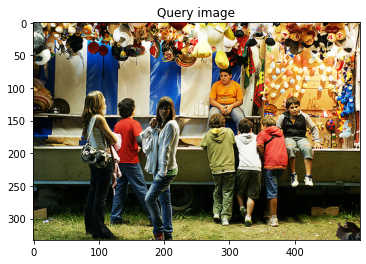

  0%|          | 0/1 [00:00<?, ?it/s]

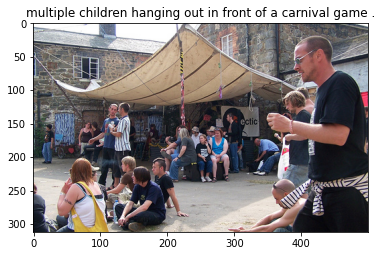

In [ ]:
example = valid_df.sample()
example_image = example['image'].values[0]
example_caption = example['caption'].values[0]

plt.imshow(images_dict_all[example_image])
plt.title('Query image')
plt.show()

find_matches_image_query(model,
                         image_embeddings, 
                         text_embeddings, 
                         valid_df, 
                         example)

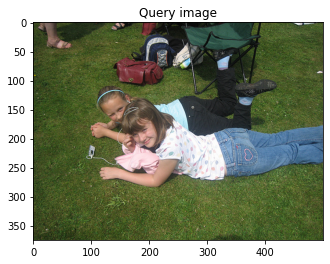

  0%|          | 0/1 [00:00<?, ?it/s]

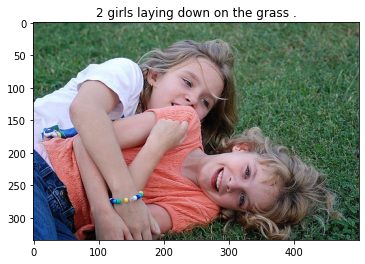

In [ ]:
example = valid_df.sample()
example_image = example['image'].values[0]
example_caption = example['caption'].values[0]

plt.imshow(images_dict_all[example_image])
plt.title('Query image')
plt.show()

find_matches_image_query(model,
                         image_embeddings, 
                         text_embeddings, 
                         valid_df, 
                         example)

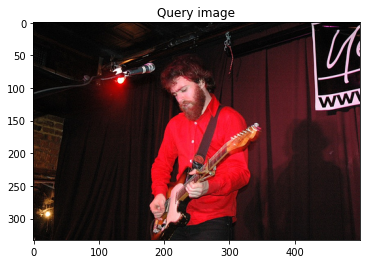

  0%|          | 0/1 [00:00<?, ?it/s]

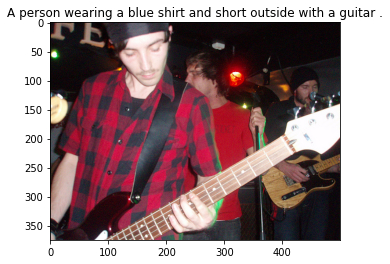

In [ ]:
example = valid_df.sample()
example_image = example['image'].values[0]
example_caption = example['caption'].values[0]

plt.imshow(images_dict_all[example_image])
plt.title('Query image')
plt.show()

find_matches_image_query(model,
                         image_embeddings, 
                         text_embeddings, 
                         valid_df, 
                         example)

In [ ]:
!ls

'Assignment - Interview Round 2.gdoc'   captions.csv	     Extras
 best_model.pkl			        CLIP-Pytorch.ipynb
 best.pt			        dataset


In [ ]:
valid_df.to_csv('valid_df.csv')

In [ ]:
np.save('image_embeddings.npy', image_embeddings.cpu().detach().numpy())  
np.save('text_embeddings.npy', text_embeddings.cpu().detach().numpy())  